# T028 · Kinase similarity: Compare different perspectives

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will compare different perspectives on kinase similarity, which were discussed in detail in previous notebooks:

* **Talktorial T024**: Kinase pocket sequences (KLIFS pocket sequences)
* **Talktorial T025**: Kinase pocket structures (KiSSim fingerprint based on KLIFS pocket residues)
* **Talktorial T026**: Kinase-ligand interaction profiles (KLIFS IFPs based on KLIFS pocket residues)
* **Talktorial T027**: Ligand profiling data

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor (considering 4 different methods)

### Contents in *Practical*

* Load kinase distance matrices
* Visualize similarity for example perspective
  * Visualize kinase distance matrix as heatmap
  * Visualize similarity as dendrogram
* Visualize similarities from different perspectives
  * Preprocess distance matrices
    * Normalize matrices
    * Define kinase order
  * Visualize kinase similarities
  * Analysis of results

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Clustering and dendrograms with `scipy`: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Kinase similarity descriptor (considering 4 different methods)

- __Talktorial T024__ = KLIFS pocket sequence
- __Talktorial T025__ = KiSSim fingerprint
- __Talktorial T026__ = KLIFS interaction fingerprint
- __Talktorial T027__ = Ligand profile: ChEMBL29, bioactivity

Please refer to the talktorials for more details on each method.

## Practical

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load kinase distance matrices

We define the paths to the kinase distance matrices.

In [5]:
kinase_distance_matrix_paths = {
    "sequence": "T024_kinase_similarity_sequence",
    "kissim": "T025_kinase_similarity_kissim",
    "ifp": "T026_kinase_similarity_ifp",
    "ligand-profile": "T027_kinase_similarity_ligand_profile"
}
kinase_distance_matrix_paths = {
    perspective: HERE / f"../{folder_name}/data/kinase_distance_matrix.csv"
    for perspective, folder_name in kinase_distance_matrix_paths.items()
}

We load the distance matrices which were generated in the previous notebooks.

In [6]:
kinase_distance_matrices = {}
for kinsim_perspective, path in kinase_distance_matrix_paths.items():
    kinase_distance_matrices[kinsim_perspective] = pd.read_csv(path, index_col=0).round(6)

3:80: E501 line too long (90 > 79 characters)


We now make a few checks to verify matrix distance conditions.

We check that the matrices have the same dimensions.

In [7]:
for descriptor, similarity_df in kinase_distance_matrices.items():
    print(f"Shape of {descriptor} matrix: {similarity_df.shape}")

Shape of sequence matrix: (9, 9)
Shape of kissim matrix: (9, 9)
Shape of ifp matrix: (9, 9)
Shape of ligand-profile matrix: (9, 9)


We check that the matrices are symmetric.

In [8]:
for descriptor, similarity_df in kinase_distance_matrices.items():
    print(f"Symmetry of {descriptor} matrix: "
          f"{(similarity_df.values == similarity_df.values.transpose()).all()}")

3:80: E501 line too long (80 > 79 characters)


Symmetry of sequence matrix: True
Symmetry of kissim matrix: True
Symmetry of ifp matrix: True
Symmetry of ligand-profile matrix: True


We check that all values are positive.

In [9]:
for descriptor, similarity_df in kinase_distance_matrices.items():
    print(f"Symmetry of {descriptor} matrix: "
          f"{(similarity_df.values >= 0).all()}")

Symmetry of sequence matrix: True
Symmetry of kissim matrix: True
Symmetry of ifp matrix: True
Symmetry of ligand-profile matrix: True


Finally, we check that the diagonal values are zero.

In [10]:
for descriptor, similarity_df in kinase_distance_matrices.items():
    print(f"Null diagonal of {descriptor} matrix: "
          f"{(np.diagonal(similarity_df) == 0).all()}")

Null diagonal of sequence matrix: True
Null diagonal of kissim matrix: True
Null diagonal of ifp matrix: True
Null diagonal of ligand-profile matrix: True


If one of the checks (dimension, symmetry, positivity, diagonal) fails, the rest of the notebook will not run and the matrix generation from the previous notebooks should be investigated.

### Visualize similarity for example perspective

In [11]:
print(f"Choices of precalculated descriptors: {kinase_distance_matrix_paths.keys()}")

1:80: E501 line too long (85 > 79 characters)


Choices of precalculated descriptors: dict_keys(['sequence', 'kissim', 'ifp', 'ligand-profile'])


We look at an example matrix:

In [12]:
descriptor_selection = "sequence"

In [13]:
kinase_distance_matrix = kinase_distance_matrices[descriptor_selection]
kinase_distance_matrix

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000000,0.059037,0.572938,0.283953,0.344972,0.351553,0.288679,0.288742,0.355356
ErbB2,0.059037,0.000000,0.586362,0.297882,0.345400,0.369692,0.314925,0.302033,0.364827
p110a,0.572938,0.586362,0.000000,0.577295,0.563541,0.576006,0.548664,0.606301,0.568806
KDR,0.283953,0.297882,0.577295,0.000000,0.328732,0.346621,0.312352,0.286194,0.346556
BRAF,0.344972,0.345400,0.563541,0.328732,0.000000,0.353245,0.327067,0.361842,0.362088
CDK2,0.351553,0.369692,0.576006,0.346621,0.353245,0.000000,0.318747,0.343975,0.276907
LCK,0.288679,0.314925,0.548664,0.312352,0.327067,0.318747,0.000000,0.309121,0.337419
MET,0.288742,0.302033,0.606301,0.286194,0.361842,0.343975,0.309121,0.000000,0.370645
p38a,0.355356,0.364827,0.568806,0.346556,0.362088,0.276907,0.337419,0.370645,0.000000


#### Visualize kinase distance matrix as heatmap

We visualize the kinase matrix in the form of a heatmap.

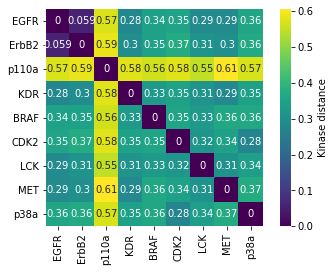

In [16]:
sns.heatmap(
    kinase_distance_matrix,
    linewidths=0,
    annot=True,
    square=True, cbar_kws={'label': 'Kinase distance'},
    cmap='viridis',
)
plt.show()

#### Visualize similarity as dendrogram

Since distance matrices are symmetric, we use the `scipy` function `squareform` to create a condensed vector of the distance matrix of shape $n*(n-1)/2$, where $n$ is the shape of the distance matrix. The values in this vector correspond to the values of the lower triangular matrix.

In [17]:
D = kinase_distance_matrix.values
D_condensed = distance.squareform(D)
D_condensed

array([0.059037, 0.572938, 0.283953, 0.344972, 0.351553, 0.288679,
       0.288742, 0.355356, 0.586362, 0.297882, 0.3454  , 0.369692,
       0.314925, 0.302033, 0.364827, 0.577295, 0.563541, 0.576006,
       0.548664, 0.606301, 0.568806, 0.328732, 0.346621, 0.312352,
       0.286194, 0.346556, 0.353245, 0.327067, 0.361842, 0.362088,
       0.318747, 0.343975, 0.276907, 0.309121, 0.337419, 0.370645])

We can submit this condensed vector to a hierarchical clustering to extract the relationship between the different kinases. We use here `method="average"`, which stands for the linkage method UPGMA (unweighted pair group method with arithmetic mean). This means that the distance between two clusters A and B is defined as the average of all distances between pairs of elements in clusters A and B. At each clustering step, the two clusters with the lowest average distance are combined.

In [18]:
hclust = hierarchy.linkage(D_condensed, method="average")

We now generate a phylogenetic tree based on the clustering.

In [19]:
tree = hierarchy.to_tree(hclust)

We visualize the tree as a dendrogram.

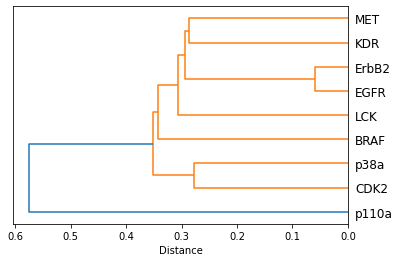

In [20]:
fig, ax = plt.subplots()
labels = kinase_distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_xlabel("Distance")
plt.show()

### Visualize similarities from different perspectives

#### Preprocess distance matrices

##### Normalize matrices 

We normalize the different matrices to values in $[0, 1]$.

In [22]:
def _min_max_normalize(distance_matrix_df):
    """
    Apply min-max normalization to input DataFrame.

    Parameters
    ----------
    kinase_distance_matrix_df : pd.DataFrame
        Kinase distance matrix.

    Returns
    -------
    pd.DataFrame
        Normalized kinase distance matrix.
    """
    min_ = distance_matrix_df.min().min()
    max_ = distance_matrix_df.max().max()
    distance_matrix_normalized_df = (distance_matrix_df - min_) / (max_ - min_)
    return distance_matrix_normalized_df

In [23]:
kinase_distance_matrices_normalized = {}
for descriptor, similarity_df in kinase_distance_matrices.items():
    similarity_normalized_df = _min_max_normalize(similarity_df)
    kinase_distance_matrices_normalized[descriptor] = similarity_normalized_df

##### Define kinase order

Define in which order to display the kinases.

In [24]:
kinase_names = kinase_distance_matrices_normalized["sequence"].columns

In [26]:
def _define_kinase_order(kinase_distance_matrix_df, kinase_names):
    """
    Define the order in which kinases shall
    appear in the input DataFrame.

    Parameters
    ----------
    kinase_distance_matrix_df : pd.DataFrame
        Kinase distance matrix.
    kinase_name : list of str
        List of kinase names to be used for sorting.

    Returns
    -------
    pd.DataFrame
        Kinase distance matrix with sorted columns/rows.
    """
    kinase_distance_matrix_df = kinase_distance_matrix_df \
        .reindex(kinase_names, axis=1) \
        .reindex(kinase_names, axis=0)
    return kinase_distance_matrix_df

In [28]:
kinase_distance_matrices_normalized = {
    descriptor: _define_kinase_order(similarity_df, kinase_names)
    for descriptor, similarity_df in kinase_distance_matrices_normalized.items()
}

3:80: E501 line too long (80 > 79 characters)


#### Visualize kinase similarities

In [30]:
def heatmap(distance_matrix, ax=None, title=""):
    """
    Generate a heatmap from a distance matrix.

    Parameters
    ----------
    distance_matrix : pd.DataFrame
        Distance matrix.
    ax : matplotlib.axes
        Plot axis to use!
    title : str
        Plot title.
    """
    sns.heatmap(
        distance_matrix,
        linewidths=0,
        annot=True,
        square=True,
        cmap='viridis',
        ax=ax
    )

In [32]:
def dendrogram(distance_matrix, ax=None, title=""):
    """
    Generate a dendrogram from a distance matrix.

    Parameters
    ----------
    distance_matrix : pd.DataFrame
        Distance matrix.
    ax : matplotlib.axes
        Plot axis to use!
    title : str
        Plot title.
    """
    D = distance_matrix.values
    D_condensed = distance.squareform(D)
    hclust = hierarchy.linkage(D_condensed, method="average")
    tree = hierarchy.to_tree(hclust)
    labels = distance_matrix.columns.to_list()
    hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Distance")

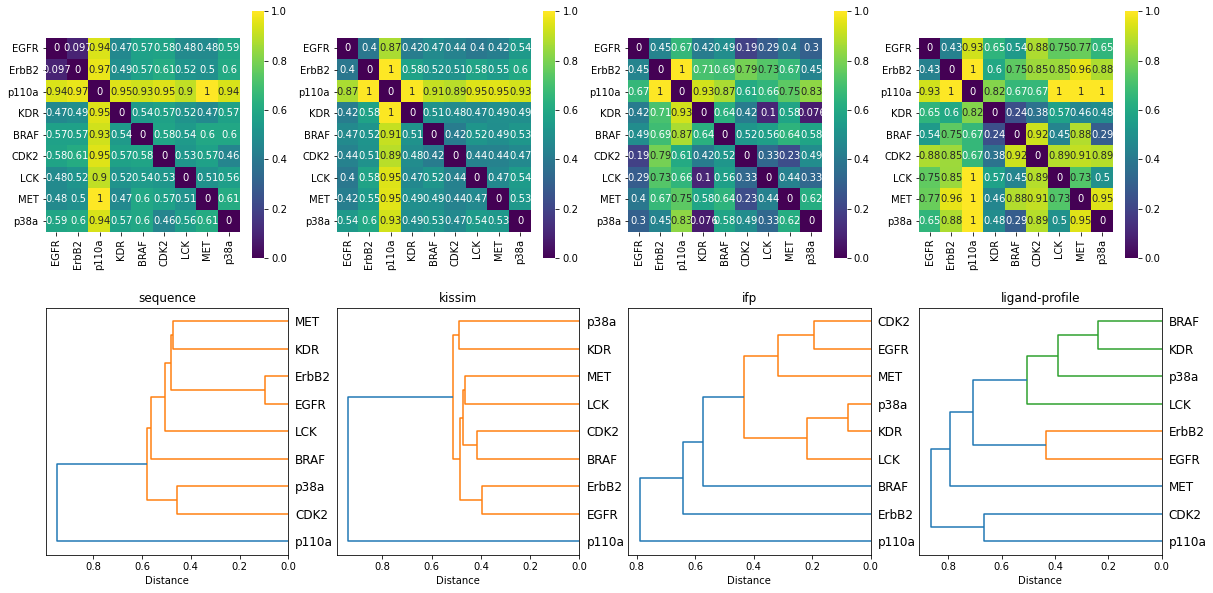

3:80: E501 line too long (87 > 79 characters)


In [33]:
n_perspectives = len(kinase_distance_matrices_normalized)
fig, axes = plt.subplots(2, n_perspectives, figsize=(n_perspectives*5, 10))
for i, (perspective, matrix) in enumerate(kinase_distance_matrices_normalized.items()):
    heatmap(matrix, ax=axes[0][i], title=perspective)
    dendrogram(matrix, ax=axes[1][i], title=perspective)

We load here again the input kinase information that we defined in __Talktorial T023__, to determine, among other, to which group each kinase belongs to.

In [34]:
kinase_selection_df = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/kinase_selection.csv")
kinase_selection_df

,kinase,kinase_klifs,uniprot_id,group,full_kinase_name
0,EGFR,EGFR,P00533,TK,Epidermal growth factor receptor
1,ErbB2,ErbB2,P04626,TK,Erythroblastic leukemia viral oncogene homolog 2
2,PI3K,p110a,P42336,Atypical,Phosphatidylinositol-3-kinase
3,VEGFR2,KDR,P35968,TK,Vascular endothelial growth factor receptor 2
4,BRAF,BRAF,P15056,TKL,Rapidly accelerated fibrosarcoma isoform B
5,CDK2,CDK2,P24941,CMGC,Cyclic-dependent kinase 2
6,LCK,LCK,P06239,TK,Lymphocyte-specific protein tyrosine kinase
7,MET,MET,P08581,TK,Mesenchymal-epithelial transition factor
8,p38a,p38a,Q16539,CMGC,p38 mitogen activated protein kinase alpha


1:80: E501 line too long (94 > 79 characters)


#### Analysis of results

- The _sequence_ approach reproduces nicely the Manning tree.
  - The TK kinases EGFR, ErbB2, MET, KDR are grouped together with highest similarities for EGFR and ErbB2.
  - The TKL kinase LCK groups next to the TK kinases.
  - The CMGC kinases p38a and CDK2 are grouped together.
  - The atypical kinase p110a is a singleton, i.e., forms its own cluster.
- When taking into account the pocket structure (physicochemical and spatial properties) with the _kissim_ approach, similar observations can be made: the typical kinases are grouped together, while the atypical kinase p110a is a singleton. Within the typical kinase grouping, EGFR and ErbB2 are the most similar.
- The _ifp_ method:
  - BRAF and the atypical kinase p110a form a singletons each.
  - Surprisingly, ErbB2 forms a singleton (=not grouped with EGFR), but we have to keep in mind that we have the least data points ($4$) for ErbB2.
- The _ligand-profile_ method:
  - CDK2 and p110a create their own cluster early on (i.e. low similarity to the rest).
  - BRAF, p38a, KDR, LCK (TKL, CMGC and TK group) as well as EGFR and ErbB2 (TK) form one cluster.
  - Surprisingly, MET (TK) forms a singleton.
- Overall observations:
  - Members of the same family (here: EGFR and ErbB2) are grouped together closely in the _sequence_ _kissim_, and _ligand-profile_ approaches.
  - The atypical kinase p110a show high dissimilarity in the _sequence_, _kissim_, and _ifp_ approaches.
  - Unexpectedly, KDR (TK) and p38a (CMGC) cluster together in all views (except for _sequence_).

<!---
- Comparison to multi-target profiles in [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629)
  - Profile 1: 
    - EGFR/ErbB2 as on-targets and BRAF as anti-target
    - Should be doable from "sequence", "ligand-profile" view (less clear from "kisim" and "ifp" view)
  - Profile 2:
    - EGFR/p110a as on-targets and BRAF as anti-target
    - Should be hard to design from all views
  - Profile 3: 
    - EGFR/KDR as on-targets and BRAF as anti-target
    - Should be hard to design except from a "sequence" view
--->

## Discussion

We have assessed kinase similarity from many different angles: the pocket sequence, the pocket structure, ligand binding modes (interaction fingerprints), and ligand bioactivities. We see from our results that different conclusions can be drawn for each methods, while some observations agree.
Thus, it is beneficial to consider different strategies to study kinase similarity.

The different approaches have strengths and drawbacks:

- The _sequence_ method: Sequence data is available for all kinases, however no information about structure or ligand binding is included.
- The _kissim_, _ifp_, and _ligand-profile_ methods: Information about structure, ligand binding, or ligand bioactivity is included, however some kinases may not have any data, some kinases may have only few data, and most kinases may not be fully explored (even if a lot of data is available).
- All methods rely on simplifications! 
  - Dealing with multiple measurements
    - _ligand-profile_ method: Only one measurement per kinase-ligand is used here.
    - _kissim_ and _ifp_ method: Only one structure/IFP pair represents one kinase pair here.
  - Bioactivity cutoffs to define active/inactive compounds in case of the _ligand-profile_ method.

## Quiz

1. Can you think of another perspective to assess kinase similarity?
2. Are there another method to assess and visualize the similarities?
3. Can you name at least one advantage and one disadvantage per perspective discussed here?
4. Could the different methods be applied to proteins in general?